# Objective:
The objective of the provided code is to demonstrate object detection using the YOLOS (You Only Look Once) model. Object detection is a computer vision task that involves identifying and locating objects of interest within an image. The YOLOS model, implemented here through the Ultralytics library, is a popular algorithm for real-time object detection.



## Model hyperparameters
Next, we define some configurations for Yolo.

### Batch normalization
Almost every convolutional layer in Yolo has batch normalization after it. It helps the model train faster and reduces variance between units (and total variance as well). Batch normalization is defined as follows.
<br>
![](https://hsto.org/files/005/d19/2bd/005d192bd6274c298f75896498aea377.png)
<br>
`_BATCH_NORM_EPSILON` refers to epsilon in this formula, whereas `_BATCH_NORM_DECAY` refers to momentum, which is used for computing moving average and variance. We use them in forward propagation during inference (after training).
<br>
<br>
`moving_average = momentum * moving_average + (1 - momentum) * current_average`

### Leaky ReLU
Leaky ReLU is a slight modification of ReLU activation function. The idea behind Leaky ReLU is to prevent so-called "neuron dying" when a large number of activations become 0.
<br>
![](https://i1.wp.com/sefiks.com/wp-content/uploads/2018/02/prelu.jpg?resize=300%2C201&ssl=1)
`_LEAKY_RELU` refers to alpha.

### Anchors
Anchors are sort of bounding box priors, that were calculated on the COCO dataset using k-means clustering. We are going to predict the width and height of the box as offsets from cluster centroids. The center coordinates of the box relative to the location of filter application are predicted using a sigmoid function.
<br>
$$b_{x} = \sigma(t_{x})+c_{x}$$
$$b_{y} = \sigma(t_{y})+c_{y}$$
$$b_{w} = p_{w}e^{t_{w}}$$
$$b_{h} = p_{h}e^{t_{h}}$$
<br>
Where $b_{x}$ and $b_{y}$ are the center coordinates of the box, $b_{w}$ and $b_{h}$ are the width and height of the box, $c_{x}$ and $c_{y}$ are the location of filter application and $t_{i}$ are predicted during regression.


`_MODEL_SIZE` refers to the input size of the model.


In [1]:
!pip install -U ultralyticsplus==0.0.14

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Usi

# Importing necessary libraries

transformers: YOLOS model and image processor

PIL: Image processing library.

torch: PyTorch for deep learning.

requests: For fetching the image from the URL.

cv2: OpenCV for image processing.

matplotlib: For displaying images.

numpy: For numerical operations on arrays.

In [1]:
from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image
import torch
import requests
import cv2
import matplotlib.pyplot as plt
import numpy as np


In [9]:
def ObjectDetection(url):
    # image = Image.open(requests.get(url, stream=True).raw)
    image=Image.open(url)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Initial Image")
    plt.axis('off')

    model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')

    image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

    inputs = image_processor(images=image, return_tensors="pt")

    outputs = model(**inputs)

    logits = outputs.logits
    bboxes = outputs.pred_boxes

    target_sizes = torch.tensor([image.size[::-1]])

    results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]

    image_np = np.array(image)

    image_with_boxes = image_np.copy()
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
        )
        cv2.rectangle(image_with_boxes, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)

    plt.subplot(1, 2, 2)
    plt.imshow(image_with_boxes)
    plt.title("Image with Bounding Boxes")
    plt.axis('off')
    plt.show()


In [11]:
url1="/content/boys.jpg"
url2="/content/girl.jpg"
url3="/content/kids.jpeg"

Detected person with confidence 0.992 at location [230.88, 95.48, 496.0, 475.5]
Detected sports ball with confidence 0.983 at location [543.39, 249.12, 635.06, 345.5]


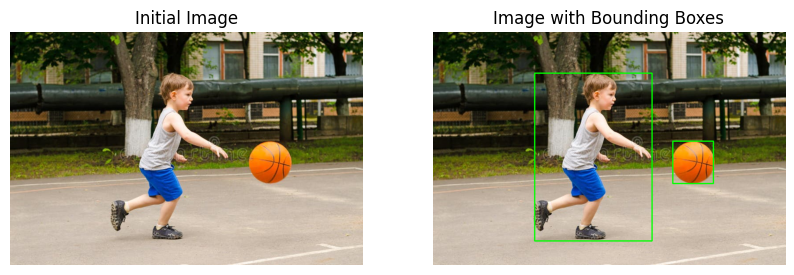

In [12]:
ObjectDetection(url1)

Detected horse with confidence 0.966 at location [151.83, 12.27, 469.37, 674.89]
Detected person with confidence 0.995 at location [57.68, 224.05, 404.91, 697.92]


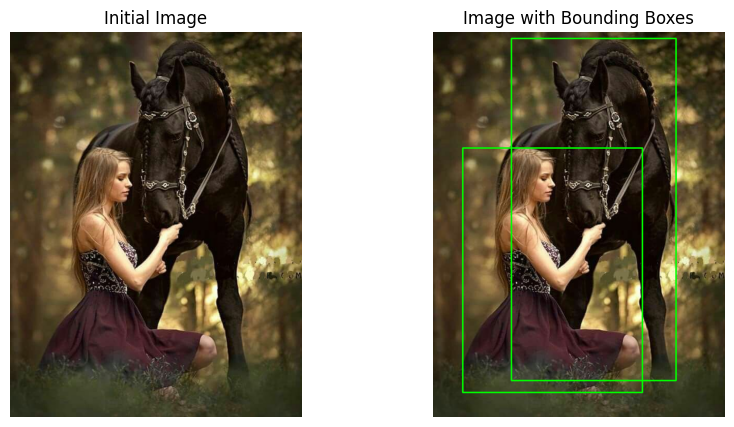

In [13]:
ObjectDetection(url2)

Detected person with confidence 0.99 at location [3.19, 38.66, 161.85, 226.15]
Detected person with confidence 0.99 at location [140.57, 53.91, 300.75, 211.64]
Detected person with confidence 0.98 at location [298.66, 56.98, 448.07, 221.2]


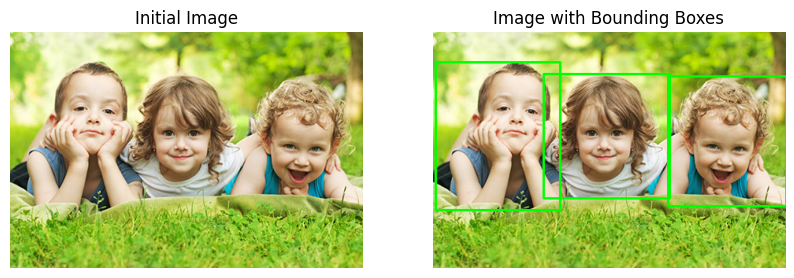

In [14]:
ObjectDetection(url3)